## Camera Calibrator

In [91]:
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
%matplotlib qt

# prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
objp = np.zeros((6*9,3), np.float32)
objp[:,:2] = np.mgrid[0:9, 0:6].T.reshape(-1,2)

# Arrays to store object points and image points from all the images.
objpoints = [] # 3d points in real world space
imgpoints = [] # 2d points in image plane.

# Make a list of calibration images
images = glob.glob('camera_cal/calibration*.jpg')

# Step through the list and search for chessboard corners
for idx, fname in enumerate(images):
    img = cv2.imread(fname)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    img_size = (img.shape[1], img.shape[0])

    # Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (9,6), None)

    # If found, add object points, image points
    if ret == True:
        objpoints.append(objp)
        imgpoints.append(corners)

# Do camera calibration given object points and image points
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img_size,None,None)

#### Testing Camera Calibrator

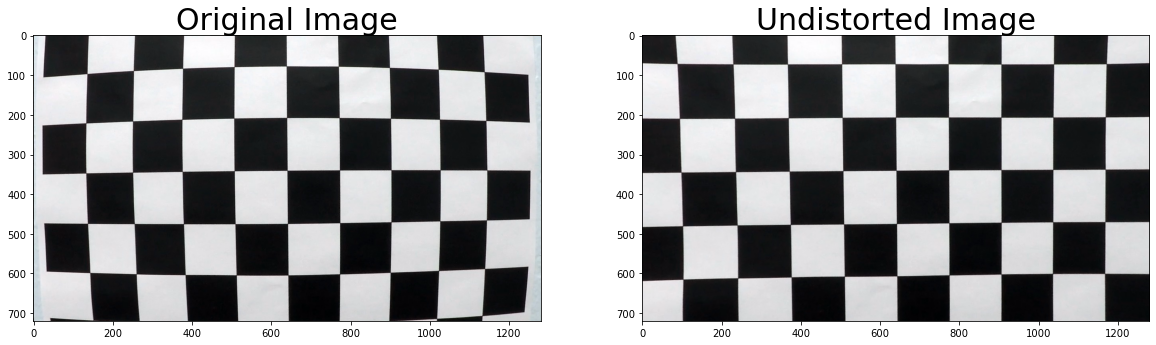

In [113]:
import pickle
%matplotlib inline

''' TESTING UNDISTROTION ON AN IMAGE '''
# load an image and undistort
src = cv2.imread('camera_cal/calibration1.jpg')
img_size = (src.shape[1], src.shape[0])
dst = cv2.undistort(src, mtx, dist, None, mtx)

# Save the camera calibration result
dist_pickle = {}
dist_pickle["mtx"] = mtx
dist_pickle["dist"] = dist
pickle.dump( dist_pickle, open( "camera_cal/wide_dist_pickle.p", "wb" ) )

# Visualize and save to a file
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.imshow(src)
ax1.set_title('Original Image', fontsize=30)
ax2.imshow(dst)
ax2.set_title('Undistorted Image', fontsize=30)
f.savefig('output_images/undistortion.png')

## Main Pipeline

In [125]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
import os
import pickle

def process_image(image_input_full):
    #Start with undistroting
    image_undistorted = apply_undistort(image_input_full,"camera_cal/wide_dist_pickle.p")
    cv2.imwrite(output_folder+'undistorted_original_'+img_name, image_undistorted)

    #Cropping the image area in a faster way for better performance
    image_cropped_rect = apply_cropping_rect(image_undistorted,90,1190,440,680)
    
    # Point list of the polygonal area on image where we want to apply our filters
    region_coordinates =[[(0,240), (490,0), (610,0), (1100,240)]]  
    image_cropped_polygonal = apply_cropping_polygonal(image_cropped_rect,region_coordinates)
    cv2.imwrite(output_folder+'image_cropped_polygonal_'+img_name, image_cropped_polygonal)
    
    ''' LANE DETECTION '''
    image_yellow = apply_filter_yellow(image_cropped_polygonal,18,110,110,  26,255,255)
    image_white = apply_filter_white(image_cropped_polygonal,212) 
    
    # Values for challenge videos
    #image_yellow = apply_filter_yellow(image_cropped_polygonal,16,70,70,  40,255,255)
    #image_white = apply_filter_white(image_cropped_polygonal,212) 
    
    # Combine two final images
    image_lanes_combined = cv2.bitwise_or(image_yellow, image_white)
    cv2.imwrite(output_folder+'binary_lanes_'+img_name, image_lanes_combined)
    
    ''' WARPING IMAGE '''
    # point lists of the polygonal area on image where we want to warp 
    region_coordinates = np.float32([[(0,240), (490+16,0), (610-16,0), (1100,240)]])
    fullframe_coordinates = np.float32([[(100,400), (100,-600), (700,-600), (700,400)]])

    # Given the perspective points, calculate the forward perspective transform matrix
    M = cv2.getPerspectiveTransform(region_coordinates, fullframe_coordinates)

    # Warp the image of the road as whites and blacks 
    warped_binary = cv2.warpPerspective(image_lanes_combined, M, (800,400))
    cv2.imwrite(output_folder+'warped_binary_'+img_name, warped_binary)
    
    # Warp the image of the road with original colors
    warped_original = cv2.warpPerspective(image_cropped_polygonal, M, (800,400))
    cv2.imwrite(output_folder+'warped_original_'+img_name, warped_original)
    
    ''' CURVE DETECTION '''
    # Get the calculations and the final image of the curve fit on lanes
    image_curvefit, image_roadarea, displacement,left_curverad, right_curverad = fit_polynomial(warped_binary)
    cv2.imwrite(output_folder+'warped_curvefit_'+img_name, image_curvefit)
    cv2.imwrite(output_folder+'warped_roadarea_'+img_name, image_roadarea)
    
    if (displacement == 999): #if no curve is detected, return the main image instead of giving error
        return image_input_full
    
    ''' COMBINING FINAL IMAGE '''
    # Given the perspective points, calculate the INVERSE of the forward perspective transform matrix
    M_inverse = cv2.getPerspectiveTransform(fullframe_coordinates, region_coordinates)
    image_roadarea_unwarped = cv2.warpPerspective(image_roadarea, M_inverse, (1100,240)) 
    
    # Merge final picture on big one
    x_offset=90
    y_offset=440
    image_combined = cv2.addWeighted(image_cropped_rect, 1.0, image_roadarea_unwarped, 0.5, 0)
    
    image_final = np.copy(image_undistorted)
    image_final[y_offset:y_offset+image_combined.shape[0], x_offset:x_offset+image_combined.shape[1]] = image_combined

    ''' PRINTING VALUES '''
    disp_info = 'Displacement : {} m'.format(int(displacement*100)/100.0)  
    curve_info = 'Curve Radius : {} m'.format((left_curverad + right_curverad)/2)
    
    image = cv2.putText(image_final, disp_info, (40,60), cv2.FONT_HERSHEY_SIMPLEX ,  1, (255, 255, 255), 2)
    image = cv2.putText(image_final, curve_info, (40,90), cv2.FONT_HERSHEY_SIMPLEX ,  1, (255, 255, 255), 2)     
        
    cv2.imwrite(output_folder+'final_'+img_name, image_final)
    
    OUTPUT_DEBUG = 1
    
    if (OUTPUT_DEBUG == 0):
        return image_final # returns the main image only
    else: 
        image_debug = np.zeros_like(image_undistorted)

        # Resize all images needed
        image_final_min = cv2.resize(image_final, (850, 600))
        image_curvefit_min = cv2.resize(image_curvefit, (430, 215))
        warped_original_min = cv2.resize(warped_original, (430, 215))
        warped_binary_min = cv2.resize(warped_binary, (430, 215))
        warped_binary_min_final = cv2.cvtColor(warped_binary_min, cv2.COLOR_GRAY2RGB)

        # Insert each image onto canvas
        image_debug[505:720, 850:1280] = image_curvefit_min  
        image_debug[260:475, 850:1280] = warped_binary_min_final
        image_debug[0:215, 850:1280] = warped_original_min 
        image_debug[110:710, 10:860] = image_final_min

        cv2.imwrite(output_folder+'Debug_'+img_name, image_debug)
        
        return image_debug  # returns the detailed image


## Subfunctions 

In [4]:
def apply_mag_thresh(img, sobel_kernel=9, mag_thresh=(30, 100)):
    global img_output
    
    # Apply the following steps to img
    # 1) Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    
    # 2) Take the gradient in x and y separately
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1,0,sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0,1,sobel_kernel)
    
    # 3) Calculate the magnitude 
    sobelxy = np.sqrt(sobelx**2 + sobely**2)
    
    # 4) Scale to 8-bit (0 - 255) and convert to type = np.uint8
    abs_sobel = np.absolute(sobelxy)
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
    
    # 5) Create a binary mask where mag thresholds are met
    binary_output = np.zeros_like(scaled_sobel)
    binary_output[(scaled_sobel >= mag_thresh[0]) & (scaled_sobel <= mag_thresh[1])] = 1
    
    # 6) Return this mask as your binary_output image
    return binary_output

In [5]:
def apply_undistort(img_input,file):
    global img_output
    
    # Read in the saved objpoints and imgpoints
    dist_pickle = pickle.load( open( file, "rb" ) )
    mtx  = dist_pickle["mtx"]
    dist = dist_pickle["dist"]
    
    # Undistrotion the image according to camera calibration data
    img_output = cv2.undistort(img_input, mtx, dist, None, mtx)
    
    return img_output

In [83]:
def apply_cropping_rect(img_input,xstart,xend,ystart,yend):
   
    #Simply crops the image
    img_output0 = img_input[ystart:yend,xstart:xend]
    
    return img_output0

In [84]:
def apply_cropping_polygonal(img_input,poly_region):
    global img_output
    
    # Crop the image with polygonal region
    mask = np.zeros_like(img_input) 
    vertices = np.array(poly_region, dtype=np.int32)
    cv2.fillPoly(mask, vertices, (255, 255, 255))
    img_output = cv2.bitwise_and(img_input, mask)
    
    return img_output

In [103]:
def apply_filter_yellow(img_input,minHue,minSat,minValue,maxHue,maxSat,maxValue):
    global img_output
    
    # Detect color YELLOW
    frameBGR = cv2.GaussianBlur(img_input, (3, 3), 0)
    
    # IMPORTANT NOTE: This function MUST behave differently for videos and images
    if ("mp4" in img_name ):
        image_hsv = cv2.cvtColor(frameBGR,cv2.COLOR_RGB2HSV)
    else:
        image_hsv = cv2.cvtColor(frameBGR,cv2.COLOR_BGR2HSV) 
    
    img_output = cv2.inRange(image_hsv, (minHue,minSat,minValue), (maxHue,maxSat,maxValue))
    
    return img_output

In [8]:
def apply_filter_white(img_input,threshold):
    global img_output
    # Detect color WHITE
    image_white = np.copy(img_input)
    white_pixels  = (image_white[:,:,0] < threshold) \
                  | (image_white[:,:,1] < threshold) \
                  | (image_white[:,:,2] < threshold)
    image_white[white_pixels] = [0,0,0]
    img_output = cv2.cvtColor(image_white,cv2.COLOR_BGR2GRAY) #returns in binary format, not RGB

    return img_output

In [59]:
def find_lane_pixels(binary_warped):
    # Take a histogram of the bottom half of the image
    histogram = np.sum(binary_warped[binary_warped.shape[0]//2:,:], axis=0)
    # Create an output image to draw on and visualize the result
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]//2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    # HYPERPARAMETERS
    # Choose the number of sliding windows
    nwindows = 9
    # Set the width of the windows +/- margin
    margin = 60
    # Set minimum number of pixels found to recenter window
    minpix = 50

    # Set height of windows - based on nwindows above and image shape
    window_height = np.int(binary_warped.shape[0]//nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated later for each window in nwindows
    leftx_current = leftx_base
    rightx_current = rightx_base

    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        
        # Draw the windows on the visualization image
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),
        (win_xleft_high,win_y_high),(0,255,0), 2) 
        cv2.rectangle(out_img,(win_xright_low,win_y_low),
        (win_xright_high,win_y_high),(0,255,0), 2) 
        
        # Identify the nonzero pixels in x and y within the window #
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]
        
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices (previously was a list of lists of pixels)
    try:
        left_lane_inds = np.concatenate(left_lane_inds)
        right_lane_inds = np.concatenate(right_lane_inds)
    except ValueError:
        # Avoids an error if the above is not implemented fully
        pass

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]

    return leftx, lefty, rightx, righty, out_img


def fit_polynomial(binary_warped):
    # Find our lane pixels first
    leftx, lefty, rightx, righty, out_img = find_lane_pixels(binary_warped)

    # Fit a second order polynomial to each using `np.polyfit`
    if (lefty.size > 0):
        left_fit = np.polyfit(lefty, leftx, 2)
    else:
        return binary_warped, binary_warped, 999, 30, 30
    
    if (righty.size > 0):
        right_fit = np.polyfit(righty, rightx, 2)
    else:
        return binary_warped, binary_warped, 999, 30, 30

    # Generate x and y values for plotting
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    try:
        left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
        right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    except TypeError:
        # Avoids an error if `left` and `right_fit` are still none or incorrect
        print('The function failed to fit a line!')
        left_fitx = 1*ploty**2 + 1*ploty
        right_fitx = 1*ploty**2 + 1*ploty

    # Colors in the left and right lane regions
    out_img[lefty, leftx] = [255, 0, 0]
    out_img[righty, rightx] = [0, 0, 255]

    # Required for measurement conversion from pixel to meter
    ym_per_pix = 30/720  # meters per pixel in y dimension
    xm_per_pix = 3.7/700 # meters per pixel in x dimension
    
    # Center of the image is 400px
    center_camera = xm_per_pix*( 400 - ((left_fitx[binary_warped.shape[0]-1] + right_fitx[binary_warped.shape[0]-1]) / 2.0))
  

    left_fit_cr = np.polyfit(lefty*ym_per_pix, leftx*xm_per_pix, 2)
    right_fit_cr = np.polyfit(righty*ym_per_pix, rightx*xm_per_pix, 2)
    
    # Define y-value where we want radius of curvature
    # We'll choose the maximum y-value, corresponding to the bottom of the image
    y_eval = np.max(ploty)
    
    # Calculation of R_curve (radius of curvature)
    left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
    right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
    
    # Drawing lines onto image
    blank_canvas = np.zeros(out_img.shape, np.uint8)
    for i in range(binary_warped.shape[0]-1):
        x1 = int(left_fitx[i])
        x2 = int(right_fitx[i])
        
        cv2.line(blank_canvas,(x1,i),(x2,i),(0, 255, 0) ,1) # GREEN Area between lanes
        cv2.line(blank_canvas,(x2,i),(x2+1,i),(255, 0, 0) ,22) # BLUE Area between lanes
        cv2.line(blank_canvas,(x1,i),(x1+1,i),(0, 0, 255) ,22) # RED Area between lanes
        
        cv2.line(out_img,(x2,i),(x2+1,i),(0, 255, 255) ,1) # YELLOW line on right lane
        cv2.line(out_img,(x1,i),(x1+1,i),(0, 255, 255) ,1) # YELLOW line on left lane
    
    
    return out_img, blank_canvas, center_camera, int(left_curverad), int(right_curverad)

## Video Convertor 

In [90]:
# Additional imports for video works
from moviepy.editor import VideoFileClip
from IPython.display import HTML

white_output = 'harder_challenge_video_output.mp4'
clip1 = VideoFileClip("harder_challenge_video.mp4")#.subclip(0,3)
white_clip = clip1.fl_image(process_image)
%time white_clip.write_videofile(white_output, audio=False)

HTML("""
<video width="1280" height="720" controls>
  <source src="{0}">
</video>
""".format(white_output))

t:   0%|                                                                            | 0/1199 [00:00<?, ?it/s, now=None]

Moviepy - Building video harder_challenge_video_output.mp4.
Moviepy - Writing video harder_challenge_video_output.mp4



Moviepy - Done !
Moviepy - video ready harder_challenge_video_output.mp4
Wall time: 7min 34s


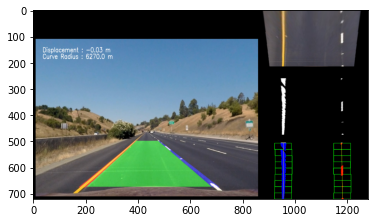

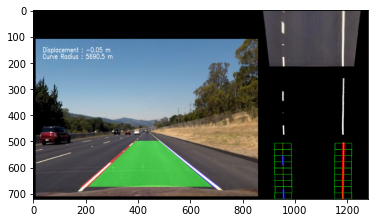

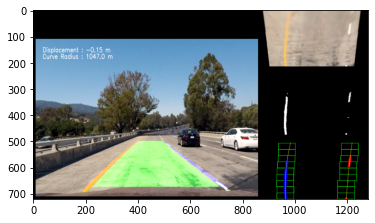

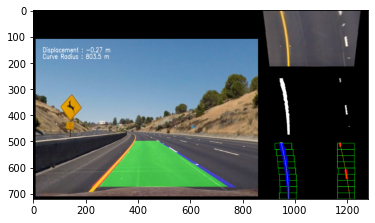

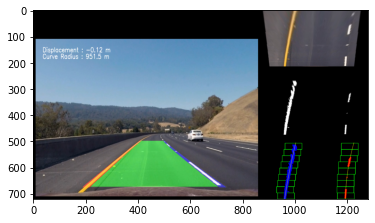

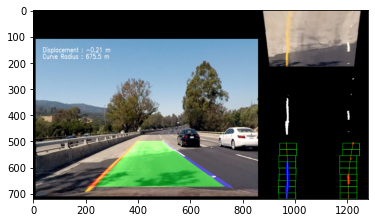

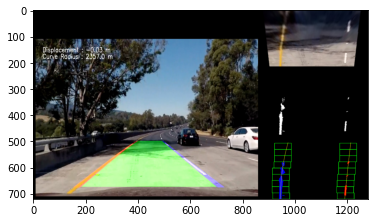

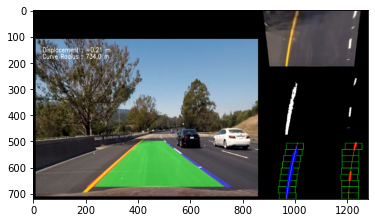

In [126]:
#Listing images 
list_images_names = os.listdir("test_images/")
output_folder = "output_images/"

#Process each images in the folder: test_images
for img_name in list_images_names:
    img_input = cv2.imread(r'test_images/'+img_name)
    img_output = process_image(img_input)    
    plt.imshow(img_output[...,::-1])
    plt.show()